# 01 - Exploración inicial de los datos de ensayos clínicos

En este notebook se realiza el análisis exploratorio de los datos (EDA) del conjunto de datos obtenido a partir de la API de ClinicalTrials.gov.

Objetivos:

- Cargar el dataset desde `data/clean/`.
- Verificar la estructura (número de filas, columnas, tipos de datos).
- Analizar valores faltantes.
- Explorar la distribución de variables clave (fase, condición, país, sponsor, etc.).
- Identificar problemas de calidad de datos relevantes para el modelado posterior.


In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np

import ast

import requests

plt.style.use("default")
pd.set_option("display.max_columns", None)

In [2]:
# Definimos rutas:

PROJECT_ROOT = Path().resolve().parent
DATA_CLEAN_DIR = PROJECT_ROOT / "data" / "clean"

CLEAN_FILENAME = "clinicaltrials_clean.csv"
data_path = DATA_CLEAN_DIR / CLEAN_FILENAME

FIGURES_DIR = PROJECT_ROOT / "reports" / "figures"
FIGURES_DIR.mkdir(exist_ok=True)

mesh_path = PROJECT_ROOT / "data" / "external" / "d2025.bin"
mesh_path.parent.mkdir(parents=True, exist_ok=True)

path = Path(data_path)
if not path.exists():
    raise FileNotFoundError(f"Archivo no encontrado: {path}")
    
if path.suffix.lower() == ".csv":
    df = pd.read_csv(path, low_memory = False)

else:
    raise ValueError(f"La extensión del archivo no es correcta (se espera .csv): {path.suffix}")

In [3]:
# Primer vistazo a los datos:

print("Shape:", df.shape)
print("\nDtypes:\n", df.dtypes)
print("\nFilas de muestra:\n", df.head(5))
print("\nValores faltantes por coplumna:")
print(df.isna().sum().sort_values(ascending=False).head(40))


Shape: (204675, 38)

Dtypes:
 NCTId                       object
BriefTitle                  object
OfficialTitle               object
OverallStatus               object
LastKnownStatus             object
StartDate                   object
PrimaryCompletionDate       object
CompletionDate              object
StudyFirstSubmitDate        object
LastUpdateSubmitDate        object
LeadSponsorName             object
LeadSponsorClass            object
BriefSummary                object
Condition                   object
Keyword                     object
StudyType                   object
Phase                       object
DesignAllocation            object
DesignInterventionModel     object
DesignPrimaryPurpose        object
DesignMasking               object
DesignWhoMasked             object
EnrollmentCount            float64
InterventionName            object
PrimaryOutcomeMeasure       object
SecondaryOutcomeMeasure     object
EligibilityCriteria         object
HealthyVolunteers        

Algunos campos de fecha no tiene día, y que algunos campos tienen muchos vacíos Tambien vemos que hay campos como Phase o Condition que son listas de valores, por lo que se tendrá que "explotar" esos campos.

In [4]:
# Vemos si hay duplicados en NCTId:
df["NCTId"].value_counts().head(10)

NCTId
NCT01315821    1
NCT06060405    1
NCT00776594    1
NCT05411094    1
NCT05948566    1
NCT04120766    1
NCT00166166    1
NCT00118066    1
NCT04708366    1
NCT01482156    1
Name: count, dtype: int64

No hay duplicados en NCTId

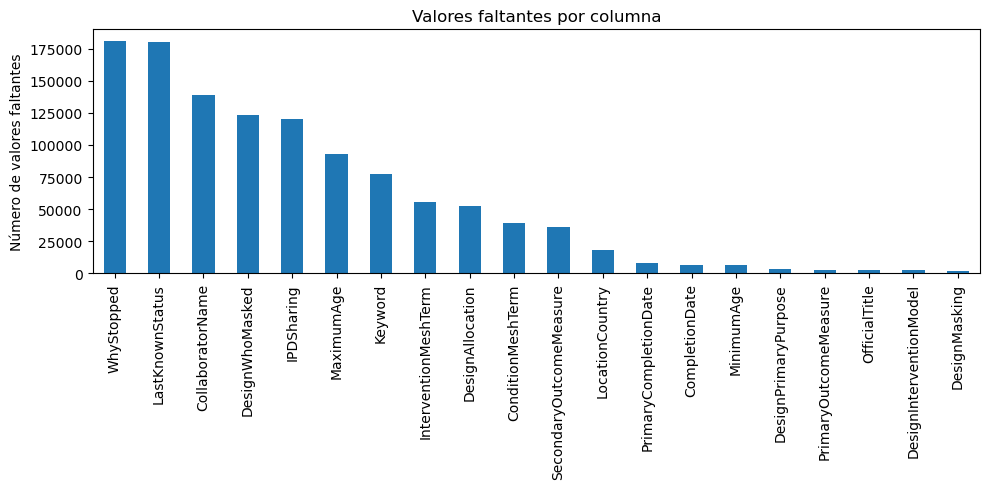

In [5]:
# Vemos que columnas acumulan mayor número de valores faltantes

missing = df.isna().sum().sort_values(ascending=False)
missing = missing[missing > 0].head(20)

if missing.empty:
    print("No hay valores faltantes.")

else:
    plt.figure(figsize=(10, 5))
    missing.plot(kind="bar")
    plt.title("Valores faltantes por columna")
    plt.ylabel("Número de valores faltantes")
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / "distribucion_valores_faltantes.png", dpi=300, bbox_inches="tight")
    plt.show()

In [6]:
df["Phase"].value_counts()

Phase
["PHASE2"]              59508
["PHASE1"]              44579
["PHASE3"]              38348
["PHASE4"]              33727
["PHASE1", "PHASE2"]    15563
["PHASE2", "PHASE3"]     7072
["EARLY_PHASE1"]         5878
Name: count, dtype: int64

In [7]:
# La columna Phase tiene listas de valores, por lo que se corrige:

def split_list(x):
    if pd.isna(x):
        return np.nan

    s = str(x).strip()

    # Caso: lista-string ["Phase 1", "Phase 2"]
    if s.startswith("[") and s.endswith("]"):
        try:
            lst = ast.literal_eval(s)
        except Exception:
            lst = [s]
    else:
        # Caso: "Phase 1/Phase 2" o "Phase 2"
        lst = [p.strip() for p in s.split("/") if p.strip()]

    if not lst:
        return np.nan
    if len(lst) == 1:
        return lst[0]              # "Phase 2"
    return " / ".join(lst)         # "Phase 1 / Phase 2"

df["Phase"] = df["Phase"].apply(split_list)
df["Phase"].value_counts()

Phase
PHASE2             59508
PHASE1             44579
PHASE3             38348
PHASE4             33727
PHASE1 / PHASE2    15563
PHASE2 / PHASE3     7072
EARLY_PHASE1        5878
Name: count, dtype: int64

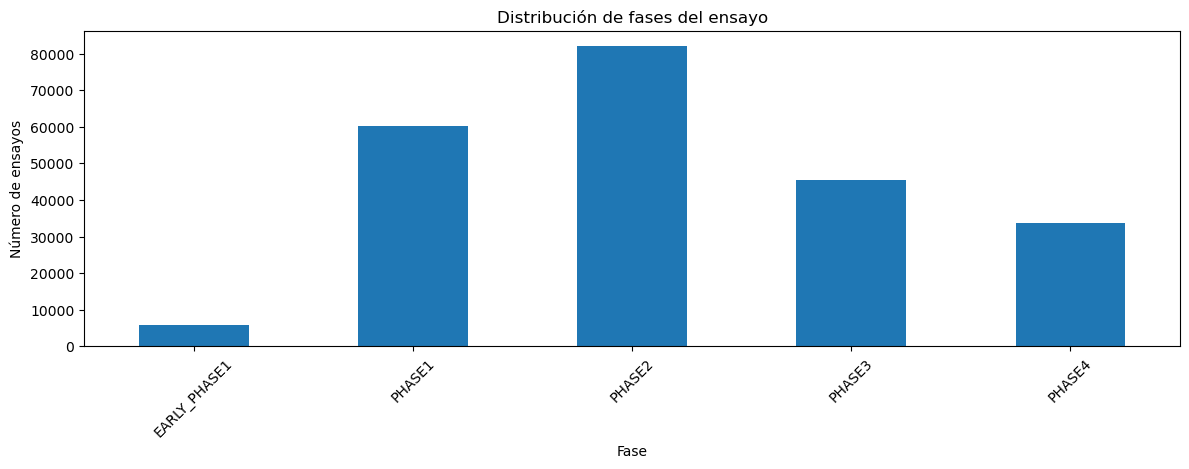

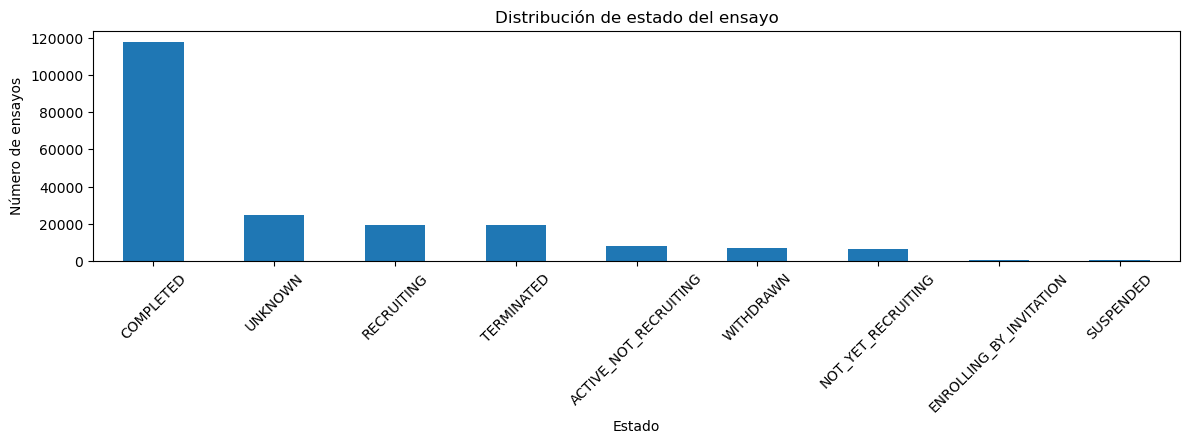

In [8]:
# A continuación se observa la dsitribución de los ensayos segun su fase o estado:

# Fase del ensayo
plt.figure(figsize=(12, 5))
phases = (df["Phase"].dropna().str.split("/").explode().str.strip())
phases.value_counts(dropna=False).sort_index().plot(kind="bar")
plt.title("Distribución de fases del ensayo")
plt.xlabel("Fase")
plt.ylabel("Número de ensayos")
plt.tight_layout()
plt.xticks(rotation=45)
plt.savefig(FIGURES_DIR / "distribucion_phase.png", dpi=300, bbox_inches="tight")
plt.show()

# Estado del ensayo 

plt.figure(figsize=(12, 5))
df["OverallStatus"].value_counts(dropna=False).plot(kind="bar")
plt.title("Distribución de estado del ensayo")
plt.xlabel("Estado")
plt.ylabel("Número de ensayos")
plt.tight_layout()
plt.xticks(rotation=45)
plt.savefig(FIGURES_DIR / "distribucion_overall_status.png", dpi=300, bbox_inches="tight")
plt.show()


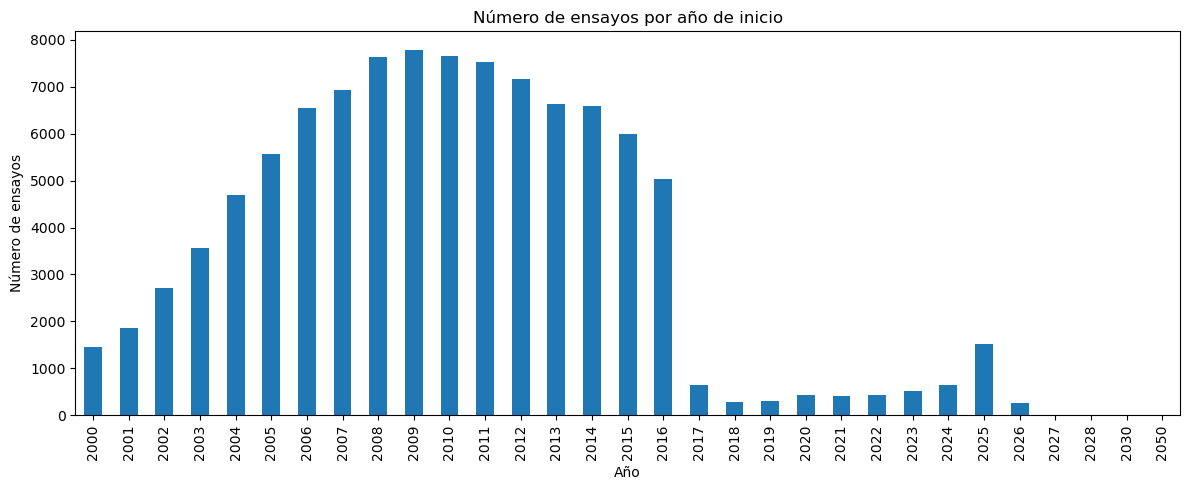

In [9]:
# Representación similar teniendo en cuenta el año de inicio:

df_date = df.copy()

# Pasamos las columnas con fechas a datetime:
for col in ["StartDate", "PrimaryCompletionDate", "CompletionDate", "LastUpdateSubmitDate", "StudyFirstSubmitDate"]:
    if col in df_date.columns:
        df_date[col] = pd.to_datetime(df_date[col], errors="coerce")

        

plt.figure(figsize=(12, 5))
df_date["StartDate"].dt.year.dropna().astype(int).value_counts().sort_index().plot(kind="bar")
plt.title("Número de ensayos por año de inicio")
plt.xlabel("Año")
plt.ylabel("Número de ensayos")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "distribucion_start_date.png", dpi=300, bbox_inches="tight")
plt.show()


In [10]:
# A partir de 2017 cae mucho el número de estudios, y eso es debido al formato de las fechas. A continuación se corrigen las fechas

date_columns = ["StartDate", "PrimaryCompletionDate", "CompletionDate", "LastUpdateSubmitDate", "StudyFirstSubmitDate"]


for col in date_columns:
    if col in df.columns:
        s = df[col].astype("string").str.strip()

        quality = pd.Series("full", index=df.index)

        quality[s.isna()] = "missing"
        quality[s.str.len() == 4] = "solo año"
        quality[s.str.len() == 7] = "año_mes"

        df[col + "_quality"] = quality

for col in date_columns:
    if col in df.columns:
        s = df[col].astype("string").str.strip()
        s_norm = s.copy()

        mask_year = s.str.len() == 4
        mask_year_month = s.str.len() == 7

        s_norm[mask_year] = s_norm[mask_year] + "-01-01"
        s_norm[mask_year_month] = s_norm[mask_year_month] + "-01"

        df[col] = pd.to_datetime(s_norm, errors="coerce")

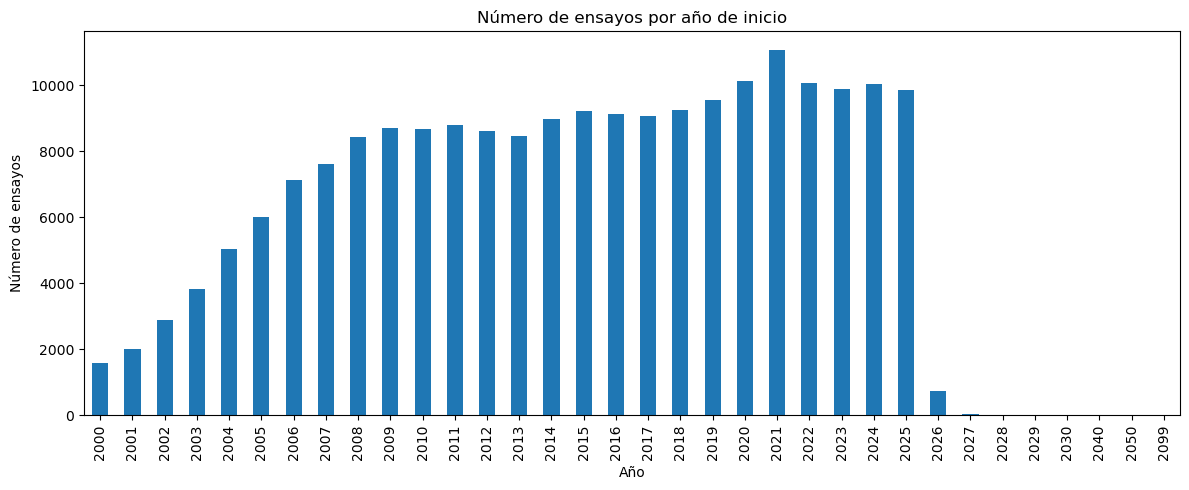

In [11]:
plt.figure(figsize=(12, 5))
df["StartDate"].dt.year.value_counts().sort_index().plot(kind="bar")
plt.title("Número de ensayos por año de inicio")
plt.xlabel("Año")
plt.ylabel("Número de ensayos")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "distribucion_start_date_2.png", dpi=300, bbox_inches="tight")
plt.show()

El grafico anterior muesta valores mas alineados con lo esperado, vemos pocos ensayos que empiecen en 2026 o adelante.

In [12]:
# Para Condition seguimos teniendo listas de vlaores
df["ConditionMeshTerm"].value_counts()

ConditionMeshTerm
[{"term": "Breast Neoplasms"}]                                                                                                                                                                                                                3354
[{"term": "Carcinoma, Non-Small-Cell Lung"}]                                                                                                                                                                                                  2318
[{"term": "Diabetes Mellitus, Type 2"}]                                                                                                                                                                                                       2296
[{"term": "Prostatic Neoplasms"}]                                                                                                                                                                                                             2148
[{"term": 

In [13]:
def parse_mesh_list(x):
    """Convierte la columna ConditionMeshTerm en lista de términos MeSH."""
    if pd.isna(x):
        return []
    try:
        items = ast.literal_eval(x)
        return [d["term"] for d in items if "term" in d]
    except:
        return []
        
df["ConditionMeshList"] = df["ConditionMeshTerm"].apply(parse_mesh_list)


In [14]:
# Usamos solo el primer termino de ConditionMeshList

def get_primary_mesh(lst):
    if isinstance(lst, list) and len(lst) > 0:
        return lst[0]
    return None

df["PrimaryConditionMesh"] = df["ConditionMeshList"].apply(get_primary_mesh)
df["PrimaryConditionMesh"].value_counts()

PrimaryConditionMesh
Breast Neoplasms                  4830
Carcinoma, Non-Small-Cell Lung    3360
Diabetes Mellitus, Type 2         3340
Prostatic Neoplasms               2542
Neoplasms                         2408
                                  ... 
Salivary Gland Diseases              1
Mycoplasma Infections                1
Translocation, Genetic               1
Sutton disease 2                     1
Lymphomatoid Papulosis               1
Name: count, Length: 3493, dtype: int64

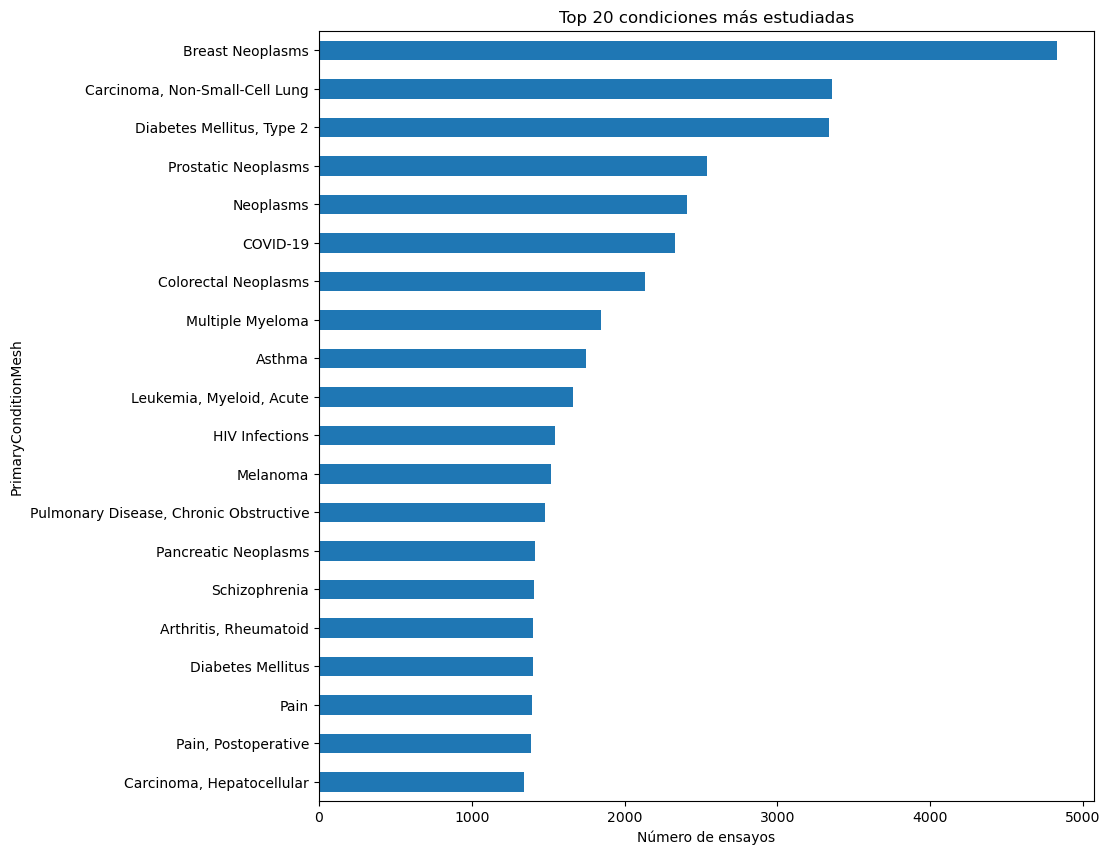

In [15]:
# Top condiciones
all_conditions = (
        df["PrimaryConditionMesh"]
        .dropna())

top_conditions = all_conditions.value_counts().head(20)

plt.figure(figsize=(10,10))
top_conditions.plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 20 condiciones más estudiadas")
plt.xlabel("Número de ensayos")
plt.savefig(FIGURES_DIR / "distribucion_condition.png", dpi=300, bbox_inches="tight")
plt.show()

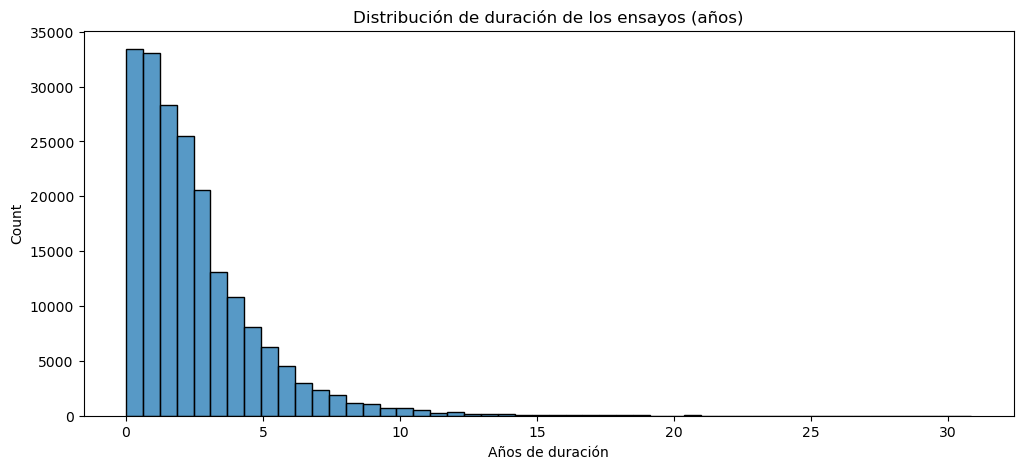

count    196714.000000
mean          2.500335
std           2.276787
min           0.000000
25%           0.920548
50%           1.923288
75%           3.397260
max          30.852055
Name: DurationPrimaryDays, dtype: float64

In [16]:
# Duración del ensayo en años

df["DurationPrimaryDays"] = (df["PrimaryCompletionDate"] - df["StartDate"]).dt.days

plt.figure(figsize=(12,5))
# Calculamos en años
sns.histplot(df["DurationPrimaryDays"].dropna()/365, bins=50)
plt.title("Distribución de duración de los ensayos (años)")
plt.xlabel("Años de duración")
plt.savefig(FIGURES_DIR / "distribucion_duración.png", dpi=300, bbox_inches="tight")
plt.show()

(df["DurationPrimaryDays"]/365).describe()


De media los ensayos se tardan 2 años y medio, y el 50% tiene una duración inferior a 2 años.

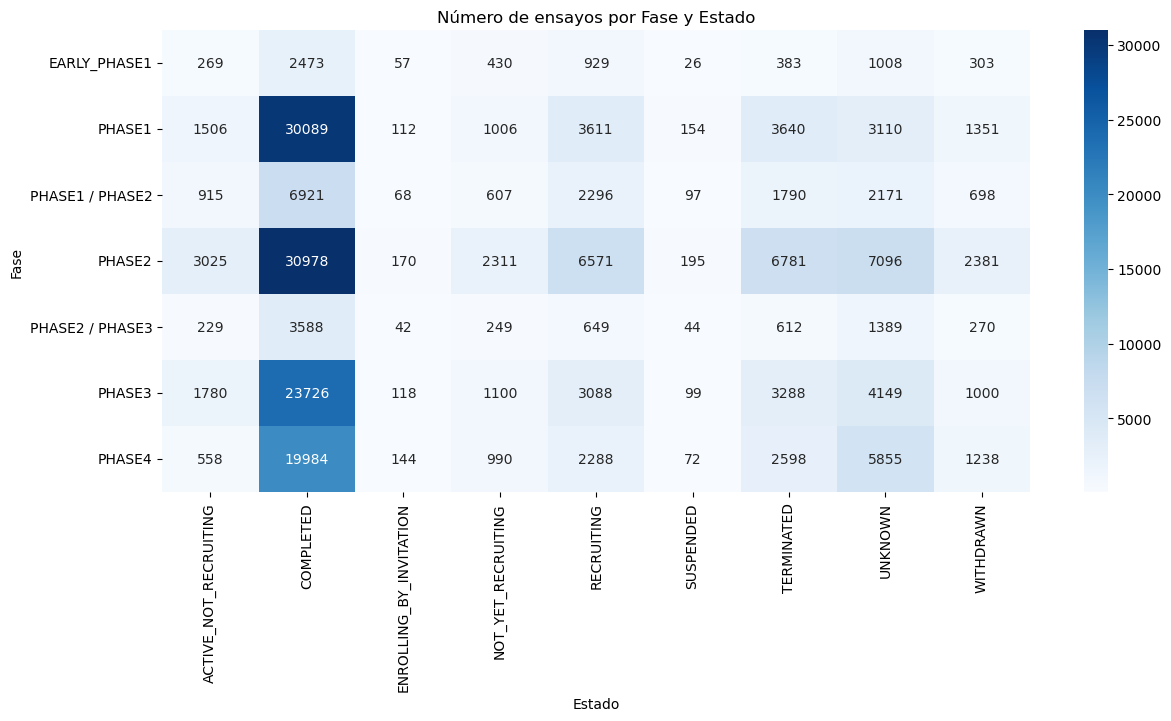

In [17]:
# Fase vs Estado
temp = pd.DataFrame({"OverallStatus": df["OverallStatus"],"Phase": df["Phase"]}).dropna()

cross_tab = pd.crosstab(temp["Phase"], temp["OverallStatus"])

plt.figure(figsize=(14,6))
sns.heatmap(cross_tab, annot=True, cmap="Blues", fmt="d")
plt.title("Número de ensayos por Fase y Estado")
plt.xlabel("Estado")
plt.ylabel("Fase")
plt.savefig(FIGURES_DIR / "distribucion_Fase_Estado.png", dpi=300, bbox_inches="tight")
plt.show()

La mayor parte de los datos estan "Completed" y/o son de Phase 1 o Phase 2.

In [18]:
df["LeadSponsorClass"].value_counts()

LeadSponsorClass
OTHER        106617
INDUSTRY      85221
NIH            5208
OTHER_GOV      3745
NETWORK        2257
FED            1291
INDIV           298
UNKNOWN          37
AMBIG             1
Name: count, dtype: int64

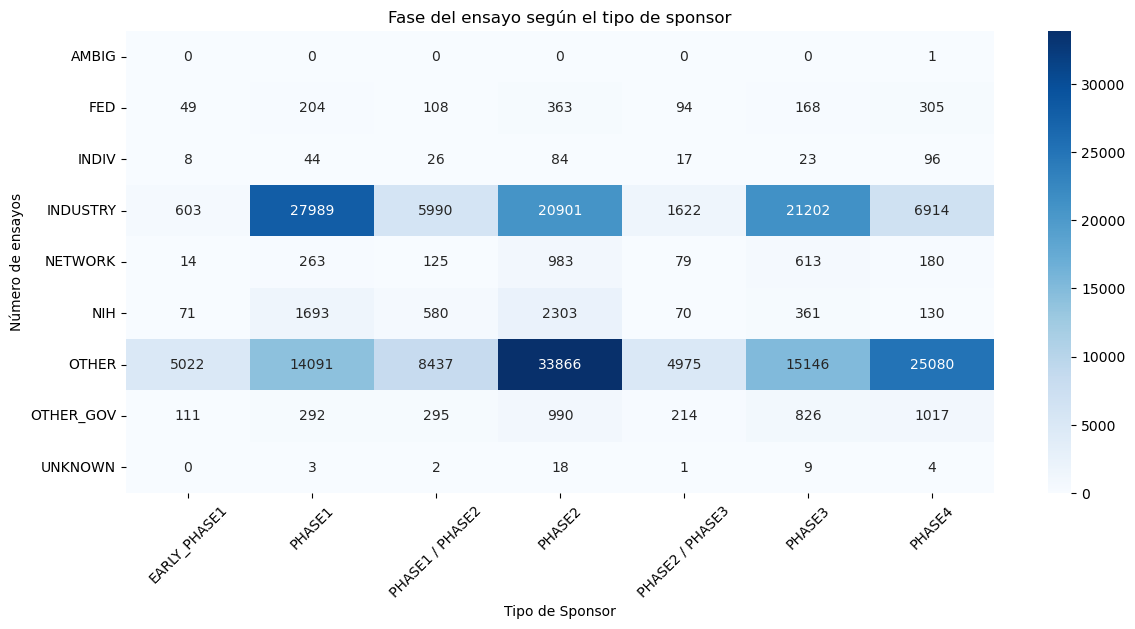

In [19]:
# Sponsor vs fase
    
temp = pd.DataFrame({"LeadSponsorClass": df["LeadSponsorClass"],"Phase": df["Phase"]}).dropna()

sponsor_phase = pd.crosstab(temp["LeadSponsorClass"], temp["Phase"])

plt.figure(figsize=(14,6))
sns.heatmap(sponsor_phase, annot=True, cmap="Blues", fmt="d")
plt.title("Fase del ensayo según el tipo de sponsor")
plt.xlabel("Tipo de Sponsor")
plt.ylabel("Número de ensayos")
plt.xticks(rotation=45)
plt.savefig(FIGURES_DIR / "distribucion_Fase_Sponsor.png", dpi=300, bbox_inches="tight")
plt.show()

El Sponsor class predominante es "OTHER" seguido de "INDUSTRY". Todos los tipos de Sponsor siguen un mismo patrón, donde predomina phase 1 y 2.

In [20]:
# Corregimos otros campos. Hacemos parsing de listas y tambien definimos los atributos primarios:
def parse_list_str(x):
    """
    '["A", "B"]' -> ["A", "B"]
    """
    if pd.isna(x):
        return []
    s = str(x).strip()
    if s.startswith("[") and s.endswith("]"):
        try:
            lst = ast.literal_eval(s)
            if isinstance(lst, list):
                return [str(v).strip() for v in lst]
        except Exception:
            pass
    return [s]

def parse_list_of_dicts(x, key):
    """
    '[{"term": "X"}, {"term": "Y"]' -> ["X", "Y"]
    """
    if pd.isna(x):
        return []
    s = str(x).strip()
    try:
        data = ast.literal_eval(s)
        if isinstance(data, list):
            out = []
            for d in data:
                if isinstance(d, dict) and key in d:
                    out.append(str(d[key]).strip())
            return out
    except Exception:
        return []
    return []


def get_primary(lst):
    '''Usar el porimer valor de la lista'''
    return lst[0] if isinstance(lst, list) and len(lst) > 0 else np.nan

def age_to_years(x):
    ''' Pasar de las diferentes unidades (year, mnoht, week, day) a años'''
    if pd.isna(x): return np.nan
    num, unit = str(x).split()[:2]
    num = float(num)
    unit = unit.lower()
    if "year" in unit: return num
    if "month" in unit: return num/12
    if "week" in unit: return num*7/365.25
    if "day" in unit: return num/365.25
    return np.nan


df["KeywordList"] = df["Keyword"].apply(parse_list_str)
df["DesignWhoMaskedList"] = df["DesignWhoMasked"].apply(parse_list_str)
df["InterventionNameList"] = df["InterventionName"].apply(lambda x: parse_list_of_dicts(x, "name"))
df["PrimaryInterventionName"] = df["InterventionNameList"].apply(get_primary)
df["PrimaryOutcomeList"] = df["PrimaryOutcomeMeasure"].apply(lambda x: parse_list_of_dicts(x, "measure"))
df["SecondaryOutcomeList"] = df["SecondaryOutcomeMeasure"].apply(lambda x: parse_list_of_dicts(x, "measure"))
df["PrimaryOutcomeMain"] = df["PrimaryOutcomeList"].apply(get_primary)
df["SecondaryOutcomeMain"] = df["SecondaryOutcomeList"].apply(get_primary)
df["CountryList"] = df["LocationCountry"].apply(lambda x: parse_list_of_dicts(x, "country"))
df["PrimaryCountry"] = df["CountryList"].apply(get_primary)
df["InterventionMeshList"] = df["InterventionMeshTerm"].apply(lambda x: parse_list_of_dicts(x, "term"))
df["PrimaryInterventionMesh"] = df["InterventionMeshList"].apply(get_primary)
df["CollaboratorList"] = df["CollaboratorName"].apply(parse_list_str)
df["PrimaryCollaborator"] = df["CollaboratorList"].apply(get_primary)

df["EnrollmentCount"] = pd.to_numeric(df["EnrollmentCount"], errors="coerce")
df["MinAgeYears"] = df["MinimumAge"].apply(age_to_years)
df["MaxAgeYears"] = df["MaximumAge"].apply(age_to_years)
df["Sex_clean"] = df["Sex"].astype(str).str.strip().str.upper().replace({"NAN": np.nan})
df["Sex_ALL"] = (df["Sex_clean"] == "ALL").astype(int)
df["Sex_FEMALE"] = (df["Sex_clean"] == "FEMALE").astype(int)
df["Sex_MALE"] = (df["Sex_clean"] == "MALE").astype(int)

In [21]:
df.head()

,NCTId,BriefTitle,OfficialTitle,OverallStatus,LastKnownStatus,StartDate,PrimaryCompletionDate,CompletionDate,StudyFirstSubmitDate,LastUpdateSubmitDate,LeadSponsorName,LeadSponsorClass,BriefSummary,Condition,Keyword,StudyType,Phase,DesignAllocation,DesignInterventionModel,DesignPrimaryPurpose,DesignMasking,DesignWhoMasked,EnrollmentCount,InterventionName,PrimaryOutcomeMeasure,SecondaryOutcomeMeasure,EligibilityCriteria,HealthyVolunteers,Sex,MinimumAge,MaximumAge,LocationCountry,ConditionMeshTerm,HasResults,InterventionMeshTerm,WhyStopped,IPDSharing,CollaboratorName,StartDate_quality,PrimaryCompletionDate_quality,CompletionDate_quality,LastUpdateSubmitDate_quality,StudyFirstSubmitDate_quality,ConditionMeshList,PrimaryConditionMesh,DurationPrimaryDays,KeywordList,DesignWhoMaskedList,InterventionNameList,PrimaryInterventionName,PrimaryOutcomeList,SecondaryOutcomeList,PrimaryOutcomeMain,SecondaryOutcomeMain,CountryList,PrimaryCountry,InterventionMeshList,PrimaryInterventionMesh,CollaboratorList,PrimaryCollaborator,MinAgeYears,MaxAgeYears,Sex_clean,Sex_ALL,Sex_FEMALE,Sex_MALE
0,NCT01315821,Effect of Saccharomyces Boulardii on Necrotizi...,Role Of Saccharomyces Boulardii in Preventin N...,UNKNOWN,RECRUITING,2011-02-01,2011-12-01,2011-12-01,2011-02-24,2011-08-04,Zekai Tahir Burak Women's Health Research and ...,OTHER,Probiotics are favorable microorganisms that r...,"[""Necrotizing Enterocolitis"", ""Very Low Birth ...","[""Saccharomyces boulardii"", ""necrotizing enter...",INTERVENTIONAL,PHASE3,RANDOMIZED,PARALLEL,PREVENTION,TRIPLE,"[""PARTICIPANT"", ""CARE_PROVIDER"", ""INVESTIGATOR""]",220.0,"[{""type"": ""DRUG"", ""name"": ""Saccharomyces boula...","[{""measure"": ""Effect of Saccharomyces boulardi...","[{""measure"": ""Effect of Saccharomyces boulardi...",Inclusion Criteria: * Very low birth weight i...,False,ALL,1 Day,2 Months,"[{""country"": ""Turkey (Türkiye)""}]","[{""term"": ""Enterocolitis, Necrotizing""}]",False,NaN,NaN,NaN,NaN,año_mes,año_mes,año_mes,full,full,"[Enterocolitis, Necrotizing]","Enterocolitis, Necrotizing",303.0,"[Saccharomyces boulardii, necrotizing enteroco...","[PARTICIPANT, CARE_PROVIDER, INVESTIGATOR]","[Saccharomyces boulardii, Placebo]",Saccharomyces boulardii,[Effect of Saccharomyces boulardii on necrotiz...,[Effect of Saccharomyces boulardii on culture ...,Effect of Saccharomyces boulardii on necrotizi...,Effect of Saccharomyces boulardii on culture p...,[Turkey (Türkiye)],Turkey (Türkiye),[],NaN,[],NaN,0.002738,0.166667,ALL,1,0,0
1,NCT04551521,CRAFT: The NCT-PMO-1602 Phase II Trial,Continuous ReAssessment With Flexible ExTensio...,COMPLETED,NaN,2021-10-13,2024-12-30,2024-12-30,2020-07-24,2025-01-07,German Cancer Research Center,OTHER,Whole-genome and transcriptome sequencing of p...,"[""Metastatic or Locally Advanced Malignancies""]",NaN,INTERVENTIONAL,PHASE2,NON_RANDOMIZED,PARALLEL,TREATMENT,NONE,NaN,72.0,"[{""type"": ""DRUG"", ""name"": ""Vemurafenib""}, {""ty...","[{""measure"": ""Disease Control Rate""}]","[{""measure"": ""Progression-free survival""}]",Inclusion Criteria: * Provision of written in...,False,ALL,18 Years,NaN,"[{""country"": ""Germany""}, {""country"": ""Germany""...","[{""term"": ""Neoplasm Metastasis""}]",False,"[{""term"": ""Vemurafenib""}, {""term"": ""cobimetini...",NaN,NaN,NaN,full,full,full,full,full,[Neoplasm Metastasis],Neoplasm Metastasis,1174.0,[],[],"[Vemurafenib, Cobimetinib, Atezolizumab, Trast...",Vemurafenib,[Disease Control Rate],[Progression-free survival],Disease Control Rate,Progression-free survival,"[Germany, Germany, Germany, Germany, Germany, ...",Germany,"[Vemurafenib, cobimetinib, atezolizumab, Trast...",Vemurafenib,[],NaN,18.000000,NaN,ALL,1,0,0
2,NCT04086121,A Study to Test the Long-term Safety of BI 655...,An Open Label Extension Study to Assess the Lo...,TERMINATED,NaN,2019-09-24,2021-04-28,2022-02-23,2019-09-10,2025-02-10,Boehringer Ingelheim,INDUSTRY,To assess the long term safety and efficacy of...,"[""Dermatitis, Atopic""]",NaN,INTERVENTIONAL,PHAS

In [22]:
output_path = DATA_CLEAN_DIR / "clinicaltrials_clean_mesh.csv"
df.to_csv(output_path, index=False)
output_path

WindowsPath('C:/Users/Administrador/Documents/tfm_clinicaltrials/data/clean/clinicaltrials_clean_mesh.csv')

## Comentarios

- **Calidad de datos**:
  - Se observan valores faltantes en varias columnas importantes, especialmente en las fechas (PrimaryCompletionDate, CompletionDate) ademas de que StartDate tenía un formato donde el día no se especifica, por lo que se ha imputado el primer día de ese mes.
  - La columna Condition toma valores muy heterogéneos (sinónimos, variaciones ortográficas). Se ha aplicado un proceso de normalización mediante MeSH (ASCII MeSH d2025.bin), para unificar términos clínicos en descriptores comunes.
  - Tras verificar la columna NCTId, no se han identificado duplicados. Esto se debe a que la API de ClinicalTrials.gov v2 devuelve únicamente la versión más reciente de cada estudio, por lo que cada ensayo aparece exactamente una vez en el dataset.
  - La categoría LeadSponsorClass presenta una elevada porporción de valores "OTHER", por lo que limíta su utilidad.

- **Distribución de fases**:
  - La distribución por fases está desbalanceada:
      - Las fases Phase 1 y Phase 2 concentran la mayor parte de los ensayos, lo que refleja su papel central en el desarrollo clínico.
      - Las fases mas tardías (Phase 4) o fases preliminares (Early Phase 1) son menos frecuentes.
  - Este desbalance afecta a las comparaciones entre fases, por lo que condiciona que modelos predictivos se pueden usar, y que los análisis deben interpretarse con rigor para fases con pocos datos.

- **Distribución temporal**:
  - Los ensayos muestran un incremento progresivo desde 2005–2007. A partir de 2010, el número de registros anuales se estabiliza en valores altos.
  - En 2020–2021 se observa un pico significativo asociado a la pandemia de COVID-19, seguido de una normalización en los años posteriores